In [5]:
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s gdrive/'Team Drives'/'Data Mining Team'/ gdata

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import sqlite3
from textblob import TextBlob
import spacy
from tqdm import tqdm
import pickle
import keras
import re
from sklearn import metrics
import scipy as sp

In [0]:
df = pickle.load(open("gdata/release/ModifiedData_wTokenized.pkl", 'rb'))
#df = df.head(12000)

In [9]:
print(df['Target'].value_counts())
print(len(df))

0    420784
1    267544
Name: Target, dtype: int64
688328


In [10]:
#Train on other features
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
dfType = df.dtypes.apply(lambda x: x.name).to_dict()
df_ros, _ = ros.fit_resample(df, df['Target'])
df = pd.DataFrame(df_ros, columns=df.columns).astype(dfType)
print(len(df))

841568


In [0]:
df.head()

,date,reviewID,reviewerID,reviewContent,rating,usefulCount,coolCount,funnyCount,hotelID,Target,reviewLength,sentimentPolarity,sentimentSubjectivity,tokenized
0,6/8/2011,MyNjnxzZVTPq,IFTr6_6NI4CgCVavIL9k5g,Let me begin by saying that there are two kind...,5,18,11,28,tQfLGoolUMu2J0igcWcoZg,0,2249.0,0.025111,0.569762,let begin saying kinds people tokyo hotel 5 st...
1,8/30/2011,BdD7fsPqHQL73hwENEDT-Q,c_-hF15XgNhlyy_TqzmdaA,The only place inside the Loop that you can st...,3,0,3,4,tQfLGoolUMu2J0igcWcoZg,0,261.0,-0.046875,0.625000,the place inside loop stay 55/night also place...
2,6/26/2009,BfhqiyfC,CiwZ6S5ZizAFL5gypf8tLA,I have walked by the Tokyo Hotel countless tim...,5,12,14,23,tQfLGoolUMu2J0igcWcoZg,0,1239.0,0.172028,0.615385,i walked tokyo hotel countless times it remind...
3,9/16/2010,Ol,nf3q2h-kSQoZK2jBY92FOg,"If you are considering staying here, watch thi...",1,8,2,6,tQfLGoolUMu2J0igcWcoZg,0,80.0,0.250000,0.333333,if considering staying watch http://www.youtub...
4,2/5/2010,i4HIAcNTjabdpG1K4F5Q2g,Sb3DJGdZ4Rq__CqxPbae-g,"This place is disgusting, absolutely horrible,...",3,11,4,9,tQfLGoolUMu2J0igcWcoZg,0,251.0,-0.435000,0.505000,this place disgusting absolutely horrible seco...


In [0]:
from sklearn.model_selection import train_test_split

y = df['Target']
X = df.drop(['Target'], axis=1)

# Split the train data into X_train and y_train datasets in 80:20 ratio.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

#X_train, X_combine, y_train, y_combine = train_test_split(
#    X_train, y_train, test_size=0.2, random_state=42)

print("Train data shape : " + str(X_train.shape))
#print("Combine data shape : " + str(X_combine.shape))
print("Test data shape : " + str(X_test.shape))
print(y_train.value_counts())
#print(y_combine.value_counts())
print(y_test.value_counts())

Train data shape : (673254, 13)
Test data shape : (168314, 13)
1    336874
0    336380
Name: Target, dtype: int64
0    84404
1    83910
Name: Target, dtype: int64


In [0]:
from nltk import FreqDist

def get_frequent_words(x, terms=100):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()
  
  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
  
  # selecting top n most frequent words
  d = words_df.nlargest(columns="count", n = terms) 
  return d

plotData = get_frequent_words(df['tokenized'])



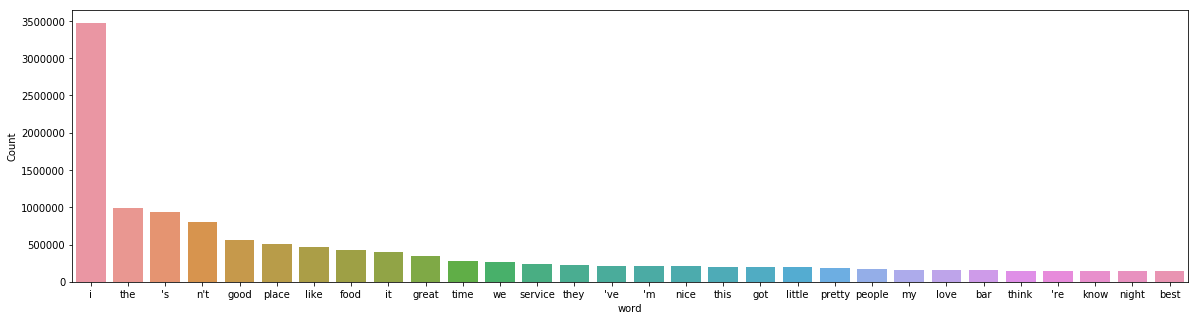

In [0]:
# function to plot top n most frequent words
def freq_words(d):
  d = d.nlargest(columns="count", n=30)
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=d, x= "word", y = "count")
  ax.set(ylabel = 'Count')
  plt.show()

#plotData = plotData.drop([45, 91, 337])
freq_words(plotData)

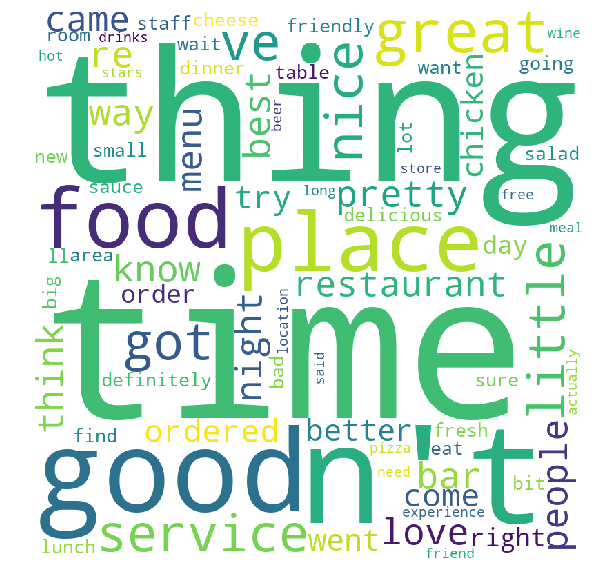

In [0]:
from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS) 

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(' '.join(plotData['word'])) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [0]:
#Ref: https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html
#Don't fit test data. Only transform it.

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X_train_idf = vectorizer.fit_transform(X_train['tokenized'])
X_test_idf = vectorizer.transform(X_test['tokenized'])

print(X_train_idf.shape)
#print(X_combine_idf.shape)
print(X_test_idf.shape)
print(y_train.shape)
#print(y_combine.shape)
print(y_test.shape)

(673254, 234217)
(168314, 234217)
(673254,)
(168314,)


In [0]:
#Train Naive Bayes - On CSR matrix
from sklearn.naive_bayes import MultinomialNB

nbModel = MultinomialNB().fit(X_train_idf, y_train)

df = pickle.dump(nbModel, open("gdata/nbModel.pkl", 'wb'))

predicted = nbModel.predict(X_test_idf)


print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.71      0.60      0.65     84404
           1       0.65      0.75      0.70     83910

   micro avg       0.68      0.68      0.68    168314
   macro avg       0.68      0.68      0.68    168314
weighted avg       0.68      0.68      0.68    168314



In [0]:
#Train using XGBoost on csr matrix
from xgboost import XGBClassifier

# fit model no training data
modelXGB = XGBClassifier(verbosity=3, random_state=42)
modelXGB.fit(X_train_idf, y_train)

# make predictions for test data
y_pred = modelXGB.predict(X_test_idf)

from sklearn import metrics

print(metrics.classification_report(y_test, y_pred))

KeyboardInterrupt: ignored

In [0]:
#Train on other features
from xgboost import XGBClassifier

X_train_features = X_train.drop(['date', 'reviewID', 'reviewerID', 'reviewContent', 'hotelID', 'tokenized'], axis=1)
X_test_features = X_test.drop(['date', 'reviewID', 'reviewerID', 'reviewContent', 'hotelID', 'tokenized'], axis=1)


# fit model no training data
modelXGB = XGBClassifier()
modelXGB.fit(X_train_features, y_train)

# make predictions for test data
y_pred = modelXGB.predict(X_test_features)

from sklearn import metrics

print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.51      0.55     84404
           1       0.56      0.63      0.60     83910

   micro avg       0.57      0.57      0.57    168314
   macro avg       0.57      0.57      0.57    168314
weighted avg       0.57      0.57      0.57    168314



In [0]:
X_train_features.head()

,rating,usefulCount,coolCount,funnyCount,reviewLength,sentimentPolarity,sentimentSubjectivity
409453,2,4,2,2,293.0,0.050000,0.262500
136673,3,0,0,0,259.0,0.258333,0.458333
809871,1,3,2,2,257.0,-0.032619,0.667381
479191,3,14,10,8,1238.0,0.115833,0.541667
443238,5,1,1,1,97.0,0.550000,0.600000


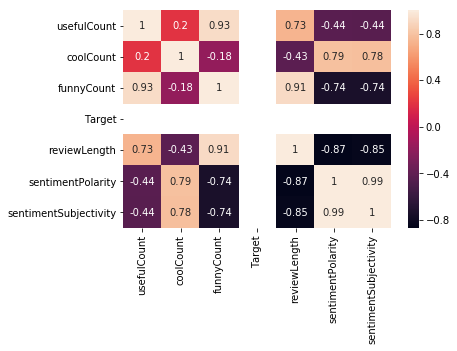

In [0]:
import seaborn as sns

flagged = df.loc[df['Target'] == 0].groupby('rating').mean()
#flagged = df.loc[df['Target'] == 0]
sns.heatmap(data=flagged.corr(), annot=True)

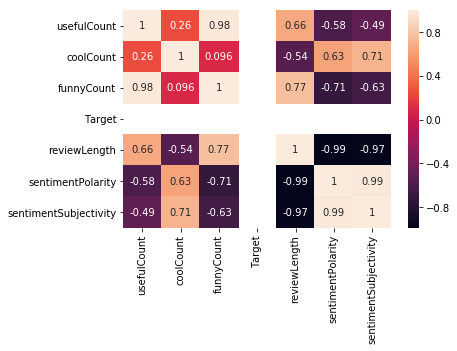

In [0]:
flagged = df.loc[df['Target'] == 1].groupby('rating').mean()
#flagged = df.loc[df['Target'] == 1]
sns.heatmap(data=flagged.corr(), annot=True)


In [0]:
#Combine models
X_combine["csrPredict"]  = nbModel.predict(X_combine_idf)

X_combine_features = X_combine.drop(['csrPredict', 'tokenized', 'date', 'reviewID', 'reviewerID', 'reviewContent', 'hotelID'], axis=1)

X_combine['featurePredict'] = modelXGB.predict(X_combine_features)



In [0]:
y = y_combine
X = X_combine[['csrPredict', 'featurePredict']].copy()

from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier()
sgd.fit(X,y)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [0]:
#Test accuracy of combined models
X_test["csrPredict"]  = nbModel.predict(X_test_idf)

X_test_features = X_test.drop(['csrPredict', 'tokenized', 'tokenized', 'date', 'reviewID', 'reviewerID', 'reviewContent', 'hotelID'], axis=1)
X_test['featurePredict'] = modelXGB.predict(X_test_features)

y = y_test
X = X_test[['csrPredict', 'featurePredict']].copy()

In [0]:
y_pred = sgd.predict(X)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.50      1.00      0.66      1722
           1       0.00      0.00      0.00      1749

   micro avg       0.50      0.50      0.50      3471
   macro avg       0.25      0.50      0.33      3471
weighted avg       0.25      0.50      0.33      3471



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
